In [16]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

from cv23_lab1_part2_utils import interest_points_visualization
from cv23_lab1_part2_utils import disk_strel

In [17]:
up = cv2.imread('up.png', cv2.IMREAD_GRAYSCALE)

cells = cv2.imread('cells.jpg', cv2.IMREAD_GRAYSCALE)

kyoto = cv2.imread('kyoto_edges.jpg', cv2.IMREAD_GRAYSCALE)

In [18]:
sigma = 2
r = 2.5
k = 0.1
theta_corn = 0.05
s = 1.5
N = 4

In [19]:
def Gaussian (I, sigma):

        n= int(np.ceil(3*sigma)*2+1)

        gauss1D = cv2.getGaussianKernel(n, sigma)  # Column vector
        gauss2D = gauss1D @ gauss1D.T  # Symmetric gaussian kernel    

        Is = cv2.filter2D(I, -1, gauss2D)
        
        return(Is)

In [20]:
def Gauss2Dfilter(sigma):
    n= int(np.ceil(3*sigma)*2+1)

    gauss1D = cv2.getGaussianKernel(n, sigma)
    gauss2D = gauss1D @ gauss1D.T
    return gauss2D

In [ ]:
    def Gaussian (I, sigma):

        n= int(np.ceil(3*sigma)*2+1)

        gauss1D = cv2.getGaussianKernel(n, sigma)  # Column vector
        gauss2D = gauss1D @ gauss1D.T  # Symmetric gaussian kernel    

        Is = cv2.filter2D(I, -1, gauss2D)
        
        return(Is)

    I= np.float32(I)

    Is = Gaussian(I, sigma)

    Ix, Iy = np.gradient(Is)

    Ix2 = np.square(Ix)
    Ixy = Ix * Iy
    Iy2 = np.square(Iy)

    j1= Gaussian(Ix2, r)
    j2= Gaussian(Ixy, r)
    j3= Gaussian(Iy2, r)


    lambda_plus = 1 / 2 * (j1 + j3 + np.sqrt((j1 - j3) ** 2 + 4 * j2 ** 2))
    lambda_minus = 1 / 2 * (j1 + j3 - np.sqrt((j1 - j3) ** 2 + 4 * j2 ** 2))

    R = lambda_plus * lambda_minus - k * (lambda_plus + lambda_minus) ** 2

    ns = np.ceil(3 * sigma) * 2 + 1
    B_sq = disk_strel(ns)
    Cond1 =( R == cv2.dilate(R, B_sq))

    maxR = np.max(R)
    Cond2 = (R > theta_corn * maxR)

   
    corners = np.zeros_like(I)

    
corners[Cond1 & Cond2] = 1
final_points = []
x_indices, y_indices = np.nonzero(corners)
final_points = np.column_stack((y_indices,x_indices, np.full_like(y_indices, sigma)))

In [21]:
def CornerDetect (I, sigma, r, k, theta_corn):

    def Gaussian (I, sigma):

        n= int(np.ceil(3*sigma)*2+1)

        gauss1D = cv2.getGaussianKernel(n, sigma)  # Column vector
        gauss2D = gauss1D @ gauss1D.T  # Symmetric gaussian kernel    

        Is = cv2.filter2D(I, -1, gauss2D)
        
        return(Is)

    I= np.float32(I)

    Is = Gaussian(I, sigma)

    Ix, Iy = np.gradient(Is)

    Ix2 = np.square(Ix)
    Ixy = Ix * Iy
    Iy2 = np.square(Iy)

    j1= Gaussian(Ix2, r)
    j2= Gaussian(Ixy, r)
    j3= Gaussian(Iy2, r)


    lambda_plus = 1 / 2 * (j1 + j3 + np.sqrt((j1 - j3) ** 2 + 4 * j2 ** 2))
    lambda_minus = 1 / 2 * (j1 + j3 - np.sqrt((j1 - j3) ** 2 + 4 * j2 ** 2))

    R = lambda_plus * lambda_minus - k * (lambda_plus + lambda_minus) ** 2

    ns = np.ceil(3 * sigma) * 2 + 1
    B_sq = disk_strel(ns)
    Cond1 =( R == cv2.dilate(R, B_sq))

    maxR = np.max(R)
    Cond2 = (R > theta_corn * maxR)

   
    corners = np.zeros_like(I)

    
    corners[Cond1 & Cond2] = 1
    final_points = []
    x_indices, y_indices = np.nonzero(corners)
    final_points = np.column_stack((y_indices,x_indices, np.full_like(y_indices, sigma)))

    return(final_points)

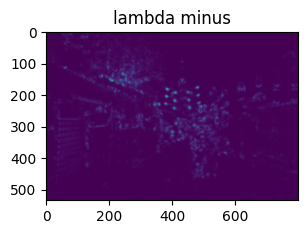

In [38]:
I= np.float32(kyoto)

Is = Gaussian(I, sigma)

Ix, Iy = np.gradient(Is)

Ix2 = np.square(Ix)
Ixy = Ix * Iy
Iy2 = np.square(Iy)

j1= Gaussian(Ix2, r)
j2= Gaussian(Ixy, r)
j3= Gaussian(Iy2, r)


lambda_plus = 1 / 2 * (j1 + j3 + np.sqrt((j1 - j3) ** 2 + 4 * j2 ** 2))
lambda_minus = 1 / 2 * (j1 + j3 - np.sqrt((j1 - j3) ** 2 + 4 * j2 ** 2))


plt.subplot(2,1,2)
plt.imshow(lambda_minus)
plt.title('lambda minus')
plt.savefig('lambda_minus.jpg')


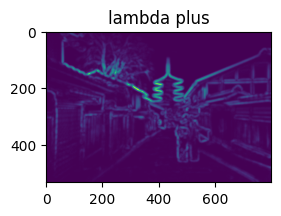

In [37]:
plt.subplot(1,2,1)
plt.imshow(lambda_plus)
plt.title('lambda plus')
plt.savefig('lambda_plus.jpg')

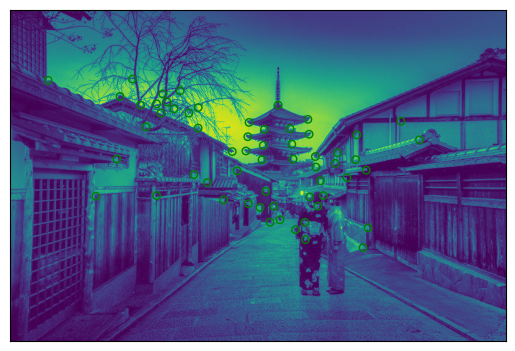

In [22]:
a= CornerDetect(kyoto, sigma, r, k, theta_corn)

interest_points_visualization(kyoto, a)

plt.savefig('CornerDetect.jpg')

2.2. Πολυκλιμακωτή Ανίχνευση Γωνιών

In [23]:
def MultiScaleCornerDetect(I, sigma, r, k, theta_corn, s, N):
    def Gauss2Dfilter(sigma):
        n= int(np.ceil(3*sigma)*2+1)

        gauss1D = cv2.getGaussianKernel(n, sigma)
        gauss2D = gauss1D @ gauss1D.T
        return gauss2D
    sigma_arr = []
    rho_arr = []
    corners = []
    LoG = []
    final_corners = []
    
    I = I.astype(float)/255

    for i in range(N):
        sigma_arr.append((s ** i) * sigma)
        rho_arr.append((s ** i) * r)

        corners.append(CornerDetect(I, sigma_arr[i], rho_arr[i], k, theta_corn))
        
        kernel = Gauss2Dfilter(sigma_arr[i])
        kernel = sigma_arr[i]**2 * cv2.Laplacian(kernel, cv2.CV_64F)
        LoG.append(np.abs(cv2.filter2D(I, -1, kernel)))
    
    for i in range(N):
        for j in range(len(corners[i])):
            # corners[i] contains all the edge points for σi
            y, x, _ = corners[i][j]
            if i == 0:
                if LoG[i+1][x, y] < LoG[i][x, y]:
                    final_corners.append([y, x, sigma_arr[i]])
                
            elif i == N-1:
                if LoG[i-1][x, y]<LoG[i][x, y]:
                    final_corners.append([y, x, sigma_arr[i]])
            else:                 
                if ((LoG[i][x, y]  > LoG[i-1][x, y]) & (LoG[i][x, y]  > LoG[i+1][x, y])):
                    final_corners.append([y, x, sigma_arr[i]])
    
    final_corners = np.array(final_corners) 
    
    return final_corners
   

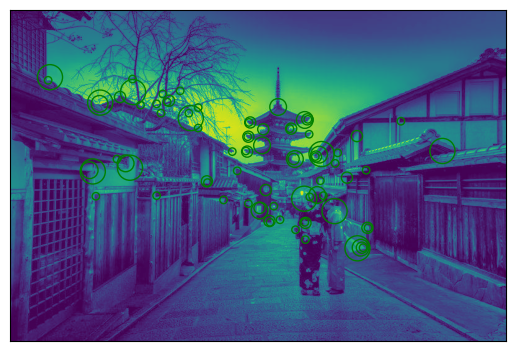

In [24]:
j = MultiScaleCornerDetect(kyoto, sigma, r, k, theta_corn, s, N )

interest_points_visualization(kyoto, j)

plt.savefig('MultiScaleCornerDetect.jpg')

2.3. Ανίχνευση Blobs

In [25]:
def BlobDetect(I, sigma, r, k, theta_corn):

    I = np.float32(I)
    Is = Gaussian(I,sigma)
    Ix, Iy = np.gradient(Is)

    Lxx = np.gradient(Ix, axis=0)
    Lyy = np.gradient(Iy, axis=1)
    Lxy = np.gradient(Ix, axis=1)

    R = Lxx * Lyy - Lxy ** 2

    ns = np.ceil(3 * sigma) * 2 + 1
    B_sq = disk_strel(ns)
    Cond1 = (R == cv2.dilate(R, B_sq))

    maxR = np.max(R)
    Cond2 = (R > theta_corn * maxR)

    blobs = np.zeros_like(I)

    
    blobs[Cond1 & Cond2] = 1
    final_points = []
    x_indices, y_indices = np.nonzero(blobs)
    final_points = np.column_stack((y_indices,x_indices, np.full_like(y_indices, sigma)))

    return(final_points)

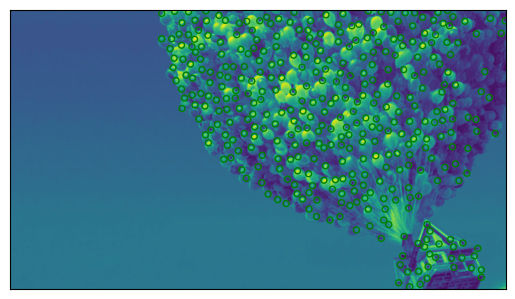

In [26]:
a= BlobDetect(up, sigma, r, k, theta_corn)
 
interest_points_visualization(up, a)

plt.savefig('BlobDetectUp.jpg')

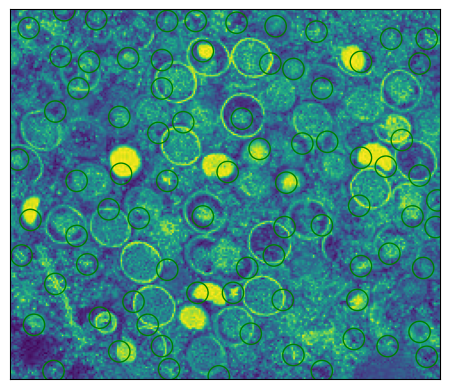

In [27]:
a= BlobDetect(cells, sigma, r, k, theta_corn)
 
interest_points_visualization(cells, a)

plt.savefig('BlobDetectCells.jpg')

In [28]:
def MultiScaleBlobDetect(I, sigma, r, k, theta_corn, s, N):
    sigma_arr = []
    rho_arr = []
    blobs = []
    LoG = []
    final_blobs = []
    
    I = I.astype(float)/255

    for i in range(N):
        sigma_arr.append((s ** i) * sigma)
        rho_arr.append((s ** i) * r)

        blobs.append(BlobDetect(I, sigma_arr[i], rho_arr[i], k, theta_corn))
            
        kernel = Gauss2Dfilter(sigma_arr[i])
        kernel = sigma_arr[i]**2 * cv2.Laplacian(kernel, cv2.CV_64F)
        LoG.append(np.abs(cv2.filter2D(I, -1, kernel)))
    
    for i in range(N):
        for j in range(len(blobs[i])):
            # corners[i] contains all the edge points for σi
            y, x, _ = blobs[i][j]
            if i == 0:
                if LoG[i+1][x, y] < LoG[i][x, y]:
                    final_blobs.append([y, x, sigma_arr[i]])
                
            elif i == N-1:
                if LoG[i-1][x, y]<LoG[i][x, y]:
                    final_blobs.append([y, x, sigma_arr[i]])
            else:                 
                if ((LoG[i][x, y]  > LoG[i-1][x, y]) & (LoG[i][x, y]  > LoG[i+1][x, y])):
                    final_blobs.append([y, x, sigma_arr[i]])
    
    final_blobs = np.array(final_blobs)  # convert list to numpy array
    
    return final_blobs

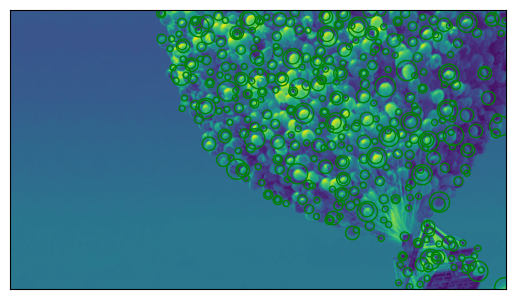

In [29]:
a= MultiScaleBlobDetect(up, sigma, r, k, theta_corn, s, N)
 
interest_points_visualization(up, a)

plt.savefig('MultiScaleBlobDetectUp.jpg')

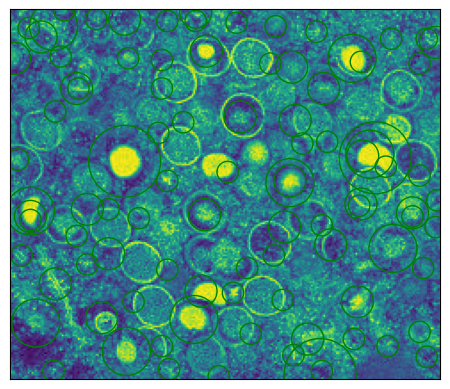

In [30]:
a= MultiScaleBlobDetect(cells, sigma, r, k, theta_corn, s, N)
 
interest_points_visualization(cells, a)

plt.savefig('MultiScaleBlobDetectCells.jpg')